In [2]:
import json
import math
import re
from random import *
import numpy as np

import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
# Open the JSON file
with open('/home/opc/final_data.json') as f:
    # Load JSON data
    data = json.load(f)
    # Print the loaded data
    #print(data)



In [4]:
# Check keys of final data
original_keys = data[0].keys()

# Print the keys
print(original_keys)


dict_keys(['user_id', 'book_id', 'authors', 'review_text', 'genre', 'description'])


In [5]:
review_text_only = [entry['review_text'] for entry in data]
genre = [entry['genre'] for entry in data]
description = [entry['description'] for entry in data]


In [6]:
description

["On a French golf course, a millionaire is found stabbed in the back! An urgent cry for help brings Poirot to France. But he arrives too late to save his client, whose brutally stabbed body now lies face downwards in a shallow grave on a golf course. But why is the dead man wearing his son's overcoat? And who was the impassioned love-letter in the pocket for? Before Poirot can answer these questions, the case is turned upside down by the discovery of a second, identically murdered corpse!",
 '"Are you happy with your life?"\nThose are the last words Jason Dessen hears before the masked abductor knocks him unconscious.\nBefore he awakens to find himself strapped to a gurney, surrounded by strangers in hazmat suits.\nBefore a man Jason\'s never met smiles down at him and says, "Welcome back, my friend."\nIn this world he\'s woken up to, Jason\'s life is not the one he knows. His wife is not his wife. His son was never born. And Jason is not an ordinary college physics professor, but a c

In [7]:
# Load BERT tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/home/opc/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
tokenized_text_genre=[]
indexed_tokens_genre=[]
for i in range(0,len(description)):
# Add the special tokens.
	marked_text_genre = "[CLS] " + genre[i] + " [SEP]"
# Split the sentence into tokens.
	tokenized_text_genre.append(tokenizer.tokenize(marked_text_genre))
# Map the token strings to their vocabulary index.
for j in range(0,len(tokenized_text_genre)):
	indexed_tokens_genre.append(tokenizer.convert_tokens_to_ids(tokenized_text_genre[j]))

In [9]:
segments_ids_genre = []
for i in range(0, len(tokenized_text_genre)):
    segments_ids_genre.append([1] * len(tokenized_text_genre[i]))

# Convert inputs to PyTorch tensors
tokens_tensors_genre = []
segments_tensors_genre = []
for i in range(0, len(indexed_tokens_genre)):
    tokens_tensors_genre.append(torch.tensor([indexed_tokens_genre[i]]))

    segments_tensors_genre.append(torch.tensor([segments_ids_genre[i]]))

In [10]:
model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True, 
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [11]:
outputs_genre = []
with torch.no_grad():
    for i in range(0, len(tokens_tensors_genre)):
        outputs_genre.append(model(tokens_tensors_genre[i], segments_tensors_genre[i]))

hidden_states_genre = []
for i in range(0, len(outputs_genre)):
    hidden_states_genre.append(outputs_genre[i][2])

In [12]:
print ("Number of layers:", len(hidden_states_genre[0]), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states_genre[0][layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states_genre[0][layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states_genre[0][layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 7
Number of hidden units: 768


In [13]:
token_embeddings_genre = []
for i in range(0, len(hidden_states_genre)):
    token_embeddings_genre.append(torch.stack(hidden_states_genre[i], dim=0))

for i in range(len(token_embeddings_genre)):
    token_embeddings_genre[i] = torch.squeeze(token_embeddings_genre[i], dim=1)

for i in range(len(token_embeddings_genre)):
    token_embeddings_genre[i] = token_embeddings_genre[i].permute(1, 0, 2)

token_vecs_cats_genre = []  # Initialize an empty list to store lists of concatenated token vectors

# For each token embedding in the list of token embeddings...
for i in range(len(token_embeddings_genre)):
    token_vecs_cat_genre= []
    # Initialize an empty list to store concatenated token vectors for the current sentence
    # For each token in the current sentence...
    for token in token_embeddings_genre[i]:
        # Concatenate the vectors from the last four layers.
        # Each layer vector is 768 values, so `cat_vec` is length 3,072.
        cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

        # Use `cat_vec` to represent `token`.
        token_vecs_cat_genre.append(cat_vec)

    # Append the list of concatenated token vectors for the current sentence to the token_vecs_cats list
    token_vecs_cats_genre.append(token_vecs_cat_genre)

print('Shape is: %d x %d' % (len(token_vecs_cats_genre[0]), len(token_vecs_cats_genre[0][0])))



Shape is: 7 x 3072


In [14]:
token_vecs_sums_genre = []

for i in range(len(token_embeddings_genre)):
    token_vecs_sum = []
    for token in token_embeddings_genre[i]:
        # `token` is a [12 x 768] tensor

        # Sum the vectors from the last four layers.
        sum_vec = torch.sum(token[-4:], dim=0)

        # Use `sum_vec` to represent `token`.
        token_vecs_sum.append(sum_vec)
    token_vecs_sums_genre.append(token_vecs_sum)

print('Shape is: %d x %d' % (len(token_vecs_sums_genre[0]), len(token_vecs_sums_genre[0][0])))

Shape is: 7 x 768


description

In [15]:
tokenized_text=[]
indexed_tokens=[]
for i in range(0,len(description)):
# Add the special tokens.
	marked_text = "[CLS] " + description[i] + " [SEP]"
# Split the sentence into tokens.
	tokenized_text.append(tokenizer.tokenize(marked_text))
# Map the token strings to their vocabulary index.
for j in range(0,len(tokenized_text)):
	indexed_tokens.append(tokenizer.convert_tokens_to_ids(tokenized_text[j]))


In [16]:
# Display the words with their index.
for i in range(0, len(indexed_tokens)):
    for tup in zip(tokenized_text[i], indexed_tokens[i]):
        print('{:<12} {:>6,}'.format(tup[0], tup[1]))


[CLS]           101
on            2,006
a             1,037
french        2,413
golf          5,439
course        2,607
,             1,010
a             1,037
millionaire  19,965
is            2,003
found         2,179
stabbed      13,263
in            1,999
the           1,996
back          2,067
!               999
an            2,019
urgent       13,661
cry           5,390
for           2,005
help          2,393
brings        7,545
po           13,433
##iro         9,711
##t           2,102
to            2,000
france        2,605
.             1,012
but           2,021
he            2,002
arrives       8,480
too           2,205
late          2,397
to            2,000
save          3,828
his           2,010
client        7,396
,             1,010
whose         3,005
brutally     23,197
stabbed      13,263
body          2,303
now           2,085
lies          3,658
face          2,227
downwards    28,457
in            1,999
a             1,037
shallow       8,467
grave         6,542


In [17]:
# Mark each of the 87 tokens as belonging to sentence "1".
segments_ids= []
for i in range(0,len(tokenized_text)):
	segments_ids.append([1] * len(tokenized_text[i])) 


In [18]:
# Convert inputs to PyTorch tensors
tokens_tensors = []
segments_tensors = []
for i in range(0,len(indexed_tokens)):
	tokens_tensors.append(torch.tensor([indexed_tokens[i]]))

	segments_tensors.append(torch.tensor([segments_ids[i]]))

In [19]:
outputs = []
with torch.no_grad():
    for i in range(0, len(tokens_tensors)):
        outputs.append(model(tokens_tensors[i], segments_tensors[i]))


In [20]:
 hidden_states = []
for i in range(0,len(outputs)):
	hidden_states.append(outputs[i][2])

In [21]:
print ("Number of layers:", len(hidden_states[0]), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[0][layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[0][layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[0][layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 112
Number of hidden units: 768


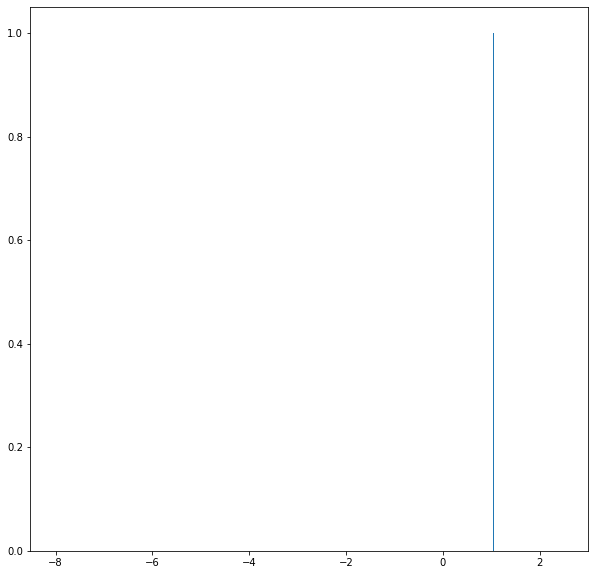

In [22]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[0][layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [23]:
print('      Type of hidden_states: ', type(hidden_states))
print('Tensor shape for each layer: ', hidden_states[1][0].size())


      Type of hidden_states:  <class 'list'>
Tensor shape for each layer:  torch.Size([1, 284, 768])


In [24]:
token_embeddings=[]
for i in range(0,len(hidden_states)):
    token_embeddings.append(torch.stack(hidden_states[i], dim=0))

token_embeddings[1].size()

torch.Size([13, 1, 284, 768])

In [25]:
for i in range(len(token_embeddings)):
    token_embeddings[i] = torch.squeeze(token_embeddings[i], dim=1)



In [26]:
for i in range(len(token_embeddings)):
    token_embeddings[i] = token_embeddings[i].permute(1,0,2)

In [27]:
token_vecs_cats = []# Initialize an empty list to store lists of concatenated token vectors

# For each token embedding in the list of token embeddings...
for i in range(len(token_embeddings)):
    token_vecs_cat = []
    # Initialize an empty list to store concatenated token vectors for the current sentence
    # For each token in the current sentence...
    for token in token_embeddings[i]:
        # Concatenate the vectors from the last four layers.
        # Each layer vector is 768 values, so `cat_vec` is length 3,072.
        cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
        
        # Use `cat_vec` to represent `token`.
        token_vecs_cat.append(cat_vec)
    
    # Append the list of concatenated token vectors for the current sentence to the token_vecs_cats list
    token_vecs_cats.append(token_vecs_cat)


print ('Shape is: %d x %d' % (len(token_vecs_cats[0]), len(token_vecs_cats[0][0])))


Shape is: 112 x 3072


In [28]:
token_vecs_sums = []

for i in range(len(token_embeddings)):
    token_vecs_sum = []
    for token in token_embeddings[i]:
    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
        sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
        token_vecs_sum.append(sum_vec)
    token_vecs_sums.append(token_vecs_sum)

print ('Shape is: %d x %d' % (len(token_vecs_sums[0]), len(token_vecs_sums[0][0])))

Shape is: 112 x 768


In [29]:
for i, token_str in enumerate(tokenized_text[2]):
  print (i, token_str)

0 [CLS]
1 robert
2 langdon
3 ,
4 harvard
5 professor
6 of
7 symbol
8 ##ogy
9 and
10 religious
11 icon
12 ##ology
13 ,
14 arrives
15 at
16 the
17 ultra
18 ##mo
19 ##dern
20 guggenheim
21 museum
22 in
23 bilbao
24 to
25 attend
26 a
27 major
28 announcement
29 -
30 -
31 the
32 un
33 ##ve
34 ##iling
35 of
36 a
37 discovery
38 that
39 "
40 will
41 change
42 the
43 face
44 of
45 science
46 forever
47 .
48 "
49 the
50 evening
51 '
52 s
53 host
54 is
55 edmond
56 ki
57 ##rs
58 ##ch
59 ,
60 a
61 forty
62 -
63 year
64 -
65 old
66 billionaire
67 and
68 fu
69 ##tur
70 ##ist
71 whose
72 dazzling
73 high
74 -
75 tech
76 inventions
77 and
78 au
79 ##da
80 ##cious
81 predictions
82 have
83 made
84 him
85 a
86 renowned
87 global
88 figure
89 .
90 ki
91 ##rs
92 ##ch
93 ,
94 who
95 was
96 one
97 of
98 langdon
99 '
100 s
101 first
102 students
103 at
104 harvard
105 two
106 decades
107 earlier
108 ,
109 is
110 about
111 to
112 reveal
113 an
114 astonishing
115 breakthrough
116 .
117 .
118 .
119 one
120 th

In [30]:

[i for i, x in enumerate(tokenized_text[2]) if x == "discovery"]

[37, 186, 351]

In [31]:
print('First 5 vector values for each instance of "face".')
print('')
print("a discovery ", str(token_vecs_sums[2][37][:5]))
print("precious discovery  ", str(token_vecs_sums[2][186][:5]))
print("shocking discovery ", str(token_vecs_sums[2][351][:5]))

First 5 vector values for each instance of "face".

a discovery  tensor([-1.5033,  3.9740,  0.0218,  0.3760,  7.0281])
precious discovery   tensor([-1.4306,  1.3720,  0.3465, -0.6882,  9.0543])
shocking discovery  tensor([-1.9919e+00,  1.9138e+00, -3.0409e-03, -2.0645e+00,  8.1142e+00])


In [32]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
diff_bank = 1 - cosine(token_vecs_sums[2][186], token_vecs_sums[2][351])

# Calculate the cosine similarity between the word bank
same_bank = 1 - cosine(token_vecs_sums[2][186], token_vecs_sums[2][37])

print('Vector similarity:  %.2f' % same_bank)
print('Vector similarity:  %.2f' % diff_bank)

Vector similarity:  0.80
Vector similarity:  0.87


In [33]:
tokenized_text_review=[]
indexed_tokens_review=[]
for i in range(0,len(review_text_only)):
# Add the special tokens.
	marked_text_review = "[CLS] " + review_text_only[i] + " [SEP]"
# Split the sentence into tokens.
	tokenized_text_review.append(tokenizer.tokenize(marked_text_review))
# Map the token strings to their vocabulary index.
for j in range(0,len(tokenized_text_review)):
	indexed_tokens_review.append(tokenizer.convert_tokens_to_ids(tokenized_text_review[j]))

In [34]:
# Display the words with their index.
for i in range(0, len(indexed_tokens_review)):
    for tup in zip(tokenized_text_review[i], indexed_tokens_review[i]):
        print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
i             1,045
haven         4,033
'             1,005
t             1,056
read          3,191
a             1,037
fun           4,569
mystery       6,547
book          2,338
in            1,999
a             1,037
while         2,096
and           1,998
not           2,025
sure          2,469
i             1,045
'             1,005
ve            2,310
ever          2,412
read          3,191
po           13,433
##iro         9,711
##t           2,102
.             1,012
was           2,001
looking       2,559
for           2,005
a             1,037
fun           4,569
read          3,191
set           2,275
in            1,999
france        2,605
while         2,096
i             1,045
was           2,001
on            2,006
holiday       6,209
there         2,045
and           1,998
this          2,023
didn          2,134
'             1,005
t             1,056
di            4,487
##sa          3,736
##pp          9,397
##oint       25,785
!               999


In [35]:
segments_ids_review = []
for i in range(0, len(tokenized_text_review)):
    segments_ids_review.append([1] * len(tokenized_text_review[i]))

# Convert inputs to PyTorch tensors
tokens_tensors_review = []
segments_tensors_review = []
for i in range(0, len(indexed_tokens_review)):
    tokens_tensors_review.append(torch.tensor([indexed_tokens_review[i]]))

    segments_tensors_review.append(torch.tensor([segments_ids_review[i]]))

In [36]:

# Define a function to handle long inputs by splitting them
def handle_long_input(input_tensor, segment_tensor, max_len=512):
    # Split the tensor into segments of max_len, with overlap if needed
    segments = []
    start = 0
    while start < input_tensor.size(1):
        end = min(start + max_len, input_tensor.size(1))
        segments.append((input_tensor[:, start:end], segment_tensor[:, start:end]))
        start += max_len
    return segments

# Process the segments
outputs_review = []
with torch.no_grad():
    for i in range(len(tokens_tensors_review)):
        if tokens_tensors_review[i].size(1) > 512:
            segmented_inputs = handle_long_input(tokens_tensors_review[i], segments_tensors_review[i])
            for tokens_tensor, segments_tensor in segmented_inputs:
                tokens_tensor = tokens_tensor.to(model.device)
                segments_tensor = segments_tensor.to(model.device)
                outputs = model(input_ids=tokens_tensor, token_type_ids=segments_tensor)
                outputs_review.append(outputs)
        else:
            tokens_tensor = tokens_tensors_review[i].to(model.device)
            segments_tensor = segments_tensors_review[i].to(model.device)
            outputs = model(input_ids=tokens_tensor, token_type_ids=segments_tensor)
            outputs_review.append(outputs)

In [37]:


# Define a function to handle long inputs by splitting them
def handle_long_input(input_tensor, segment_tensor, max_len=512):
    # Split the tensor into segments of max_len, with overlap if needed
    segments = []
    start = 0
    while start < input_tensor.size(1):
        end = min(start + max_len, input_tensor.size(1))
        segments.append((input_tensor[:, start:end], segment_tensor[:, start:end]))
        start += max_len
    return segments

# Process the segments
outputs_review = []
with torch.no_grad():
    for i in range(len(tokens_tensors_review)):
        segment_outputs = []
        if tokens_tensors_review[i].size(1) > 512:
            segmented_inputs = handle_long_input(tokens_tensors_review[i], segments_tensors_review[i])
            for tokens_tensor, segments_tensor in segmented_inputs:
                tokens_tensor = tokens_tensor.to(model.device)
                segments_tensor = segments_tensor.to(model.device)
                outputs = model(input_ids=tokens_tensor, token_type_ids=segments_tensor)
                segment_outputs.append(outputs.hidden_states)
            combined_hidden_list = []
            # Combine segment outputs
            for j in range(len(segment_outputs[0])):
                combined_hidden = segment_outputs[0][j]
                for d in range(1, len(segment_outputs)):
                    new_combined_hidden = torch.cat((combined_hidden, segment_outputs[d][j]), dim=1)
                    combined_hidden = new_combined_hidden  # Concatenate along the sequence length dimension
            
                combined_hidden_list.append(combined_hidden)  # Take the mean across the concatenated dimens
            outputs_review.append(combined_hidden_list)
        else:
            tokens_tensor = tokens_tensors_review[i].to(model.device)
            segments_tensor = segments_tensors_review[i].to(model.device)
            outputs = model(input_ids=tokens_tensor, token_type_ids=segments_tensor)
            outputs_review.append(outputs.hidden_states)  # Directly append if within size limit


In [38]:
hidden_states_review = outputs_review

In [39]:
print ("Number of layers:", len(hidden_states_review[1]), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states_review[1][layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states_review[1][layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states_review[1][layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 573
Number of hidden units: 768


In [40]:
token_embeddings_review=[]
for i in range(0,len(hidden_states_review)):
    token_embeddings_review.append(torch.stack(hidden_states_review[i], dim=0))

print(token_embeddings_review[7].size())

for i in range(len(token_embeddings_review)):
    token_embeddings_review[i] = torch.squeeze(token_embeddings_review[i], dim=1)

for i in range(len(token_embeddings_review)):
    token_embeddings_review[i] = token_embeddings_review[i].permute(1, 0, 2)
print(token_embeddings_review[7].size())

torch.Size([13, 1, 214, 768])
torch.Size([214, 13, 768])


In [41]:
token_vecs_cats_review = []  # Initialize an empty list to store lists of concatenated token vectors

# For each token embedding in the list of token embeddings...
for i in range(len(token_embeddings_review)):
    token_vecs_cat_review = []
    # Initialize an empty list to store concatenated token vectors for the current sentence
    # For each token in the current sentence...
    for token in token_embeddings_review[i]:
        # Concatenate the vectors from the last four layers.
        # Each layer vector is 768 values, so `cat_vec` is length 3,072.
        cat_vec_review = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

        # Use `cat_vec` to represent `token`.
        token_vecs_cat_review.append(cat_vec_review)

    # Append the list of concatenated token vectors for the current sentence to the token_vecs_cats list
    token_vecs_cats_review.append(token_vecs_cat_review)

print('Shape is: %d x %d' % (len(token_vecs_cats_review[7]), len(token_vecs_cats_review[7][0])))

token_vecs_sums_review = []

for i in range(len(token_embeddings_review)):
    token_vecs_sum_review = []
    for token in token_embeddings_review[i]:
        # `token` is a [12 x 768] tensor

        # Sum the vectors from the last four layers.
        sum_vec_review = torch.sum(token[-4:], dim=0)

        # Use `sum_vec` to represent `token`.
        token_vecs_sum_review.append(sum_vec_review)
    token_vecs_sums_review.append(token_vecs_sum_review)

print('Shape is: %d x %d' % (len(token_vecs_sums_review[7]), len(token_vecs_sums_review[7][0])))


stacked_tensor_review = torch.stack(token_vecs_sums_review[7])

# Convert the stacked tensor to a NumPy array
numpy_array = stacked_tensor_review.numpy()
print(numpy_array.shape)

Shape is: 214 x 3072
Shape is: 214 x 768
(214, 768)


In [42]:
for i, token_str in enumerate(tokenized_text_review[7]):
    print(i, token_str)





0 [CLS]
1 *
2 *
3 spoil
4 ##er
5 alert
6 *
7 *
8 critics
9 aside
10 ,
11 dan
12 brown
13 can
14 sure
15 write
16 a
17 thriller
18 .
19 i
20 was
21 stuck
22 in
23 an
24 airport
25 with
26 no
27 book
28 and
29 picked
30 this
31 up
32 ,
33 and
34 was
35 done
36 with
37 it
38 in
39 2
40 days
41 .
42 the
43 first
44 half
45 of
46 the
47 book
48 was
49 really
50 gripping
51 ,
52 and
53 promised
54 big
55 things
56 .
57 we
58 were
59 going
60 to
61 learn
62 about
63 the
64 secrets
65 of
66 the
67 mason
68 ##s
69 ,
70 and
71 about
72 the
73 "
74 ancient
75 wisdom
76 "
77 that
78 has
79 been
80 lost
81 through
82 the
83 ages
84 .
85 sounds
86 cool
87 -
88 i
89 wanted
90 to
91 learn
92 more
93 about
94 the
95 ancient
96 wisdom
97 .
98 but
99 the
100 end
101 of
102 the
103 book
104 just
105 fell
106 really
107 flat
108 .
109 the
110 vi
111 ##lli
112 ##an
113 was
114 predictable
115 ,
116 and
117 we
118 learned
119 nothing
120 about
121 this
122 ancient
123 wisdom
124 .
125 i
126 also
127 have
128

In [43]:
[i for i, x in enumerate(tokenized_text_review[7]) if x == "ancient"]

[74, 95, 122]

In [44]:
print('First 5 vector values for each instance of "ancient".')
print('')
print("ancient1 ", str(token_vecs_sums_review[7][74][:5]))
print("ancient2  ", str(token_vecs_sums_review[7][95][:5]))
print("ancient3 ", str(token_vecs_sums_review[7][122][:5]))

First 5 vector values for each instance of "ancient".

ancient1  tensor([-1.1099,  1.1726,  0.4913, -2.3908,  3.0886])
ancient2   tensor([-1.7257,  1.7984, -0.5318, -1.9469,  1.4118])
ancient3  tensor([-0.1392,  0.7446, -0.1009, -0.9688,  0.2888])


In [45]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sums_review[7][74], token_vecs_sums_review[7][95])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sums_review[7][74], token_vecs_sums_review[7][122])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.83
Vector similarity for *different* meanings:  0.89


In [46]:
torch.save(token_vecs_sums_review, 'review_text_bert.pt')

In [47]:
torch.save(token_vecs_sums_genre, 'genre_text_bert.pt')

In [48]:
torch.save(token_vecs_sums, 'description_text_bert.pt')